In [1]:
import cira 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from os.path import exists

cira.auth.KEY_FILE = ""
assert not cira.auth.check_keys()

SYMBOL = "ETH/USD" 
SYM_HIST_FILE = f'./{SYMBOL.replace("/", "_")}.csv'

stk = cira.Cryptocurrency(SYMBOL)

if not exists(SYM_HIST_FILE): # chacheing historical data  
    start = datetime(2021, 1, 1)
    end = datetime.now().date() 
    stk.save_historical_data(SYM_HIST_FILE, start, end)

data = stk.load_historical_data(SYM_HIST_FILE)
data.head()

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2021-01-01 06:00:00+00:00,ETH/USD,742.15,745.00,716.65,733.65,6534.81013,6514.0,731.807780
2021-01-02 06:00:00+00:00,ETH/USD,735.29,791.08,725.44,786.88,16071.74933,15214.0,769.787732
2021-01-03 06:00:00+00:00,ETH/USD,786.64,1098.00,784.55,1086.86,44039.92386,43031.0,942.620484
2021-01-04 06:00:00+00:00,ETH/USD,1086.86,1169.05,880.00,991.40,50778.44556,51353.0,1030.893782
2021-01-05 06:00:00+00:00,ETH/USD,992.00,1138.00,980.08,1105.56,25283.79028,26369.0,1073.661942


In [2]:
data.tail().iloc[-1]

symbol             ETH/USD
open              2626.759
high             2645.0495
low               2575.753
close            2643.9435
volume           19.427921
trade_count           49.0
vwap           2616.465356
Name: 2024-09-30 05:00:00+00:00, dtype: object

<Axes: xlabel='timestamp'>

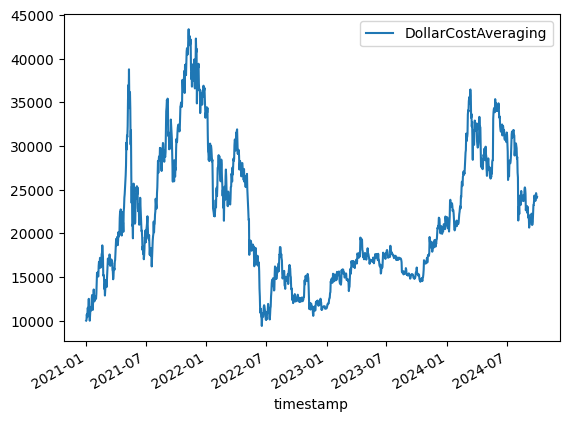

In [3]:
strat = cira.strategy.DollarCostAveraging(amount=1.1)
cira.strategy.back_test(strat, data, data["close"].to_frame(), 10_000).plot()

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [5]:
features = ['open', 'high', 'low', 'volume', 'trade_count', 'vwap']
target = 'close'

X = data[features].values
y = data[target].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [7]:
class PredictPriceNN(nn.Module):
    def __init__(self, input_dim):
        super(PredictPriceNN, self).__init__()
        self.l1 = nn.Linear(input_dim, 64)
        self.l2 = nn.Linear(64, 32)
        self.l3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.relu(self.l2(x))
        x = self.l3(x)
        return x

In [8]:
model = PredictPriceNN(input_dim=len(features))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

<Axes: >

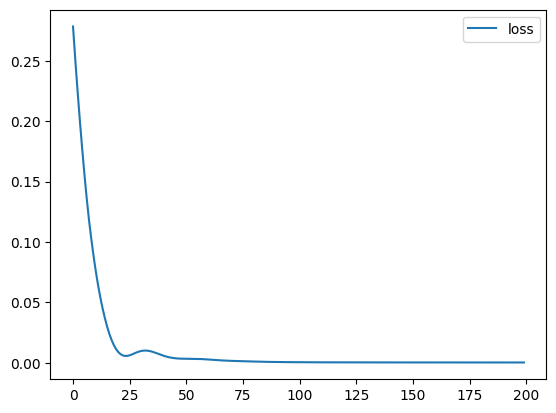

In [9]:
n_epochs = 200 
lloss = []
for epoch in range(n_epochs):
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lloss.append(loss.item())
pd.DataFrame({"loss":lloss}).plot()

In [10]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0002


In [11]:
sample = torch.FloatTensor(X_scaled[-1:])
pred = model(sample)
pred_price = scaler_y.inverse_transform(pred.detach().numpy())
print(f"Predicted closing price: ${pred_price[0][0]:.2f}")
print(f"real price was ${data.iloc[-1].close:.2f}")
print(f"Delta ${data.iloc[-1].close - pred_price[0][0]:.2f}")

Predicted closing price: $2627.70
real price was $2643.94
Delta $16.24


In [ ]:
import cira
from pandas import DataFrame
from numpy import ndarray


class NNTradingStrat(cira.strategy.Strategy):
    def __init__(self, nn_model, scaler_X, scaler_y, risk = 0.1):
        self.nn_model = nn_model
        self.risk = risk
        self.scaler_X = scaler_X
 
    def iterate(self, feature_data: DataFrame, prices: DataFrame, portfolio: ndarray, cash:float)-> ndarray: 
        _feature_data = feature_data.copy()
        self.x_scaler(_feature_data)  
        X_scaled = scaler_X.fit_transform(X)